In [1]:
import os 
import cv2
import pandas as pd
import numpy as np
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Add,AveragePooling2D,Dense, AvgPool2D,BatchNormalization, ReLU, DepthwiseConv2D, Reshape, Permute,Conv2D, MaxPool2D, GlobalAveragePooling2D, concatenate

In [2]:
foto_turu=['fake', 'real']
veri_dizini = 'train'
egitim_dizini = os.path.join(veri_dizini)
len(foto_turu)

2

In [3]:
train_data = []
for indis, foto_tur  in enumerate(foto_turu):
    print(foto_tur)
    for dosya in os.listdir(os.path.join(egitim_dizini, foto_tur)):
        train_data.append(['{}/{}'.format(foto_turu, dosya), indis, foto_turu])

train = pd.DataFrame(train_data, columns=['Dosya', 'fototurID','Foto Turu'])

SEED = 42 #rastgelelik oranı
train = train.sample(frac=1, random_state=SEED)
train.index = np.arange(len(train)) # Reset indices
#Dosyalar rastgele karıştırılıyor
len(foto_turu)

fake
real


2

In [4]:
IMAGE_SIZE = 224
def read_image(filepath):
    return cv2.imread(os.path.join(veri_dizini, filepath)) # Loading a color image is the default flag

# Resize image to target size
def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)

In [5]:
X_train = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
#X_train.shape #(2998, 224, 224, 3)

for i, file in tqdm(enumerate(train['Dosya'].values)): # 0 fake/fake_654.jpg gibi
        image = read_image(file)
        if image is not None:
            X_train[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))
        
# Normalize the data -> Veri normalize edilir
X_Train = X_train / 255.
print('Train Shape: {}'.format(X_Train.shape))

2998it [00:00, 89875.80it/s]


Train Shape: (2998, 224, 224, 3)


In [6]:
Y_train = train['fototurID'].values
Y_train = to_categorical(Y_train)
#Kategorik bir hale getiriyoruz

In [7]:
X_train, X_val, Y_train, Y_val = train_test_split(X_Train, Y_train, test_size=0.2, random_state=42)


In [8]:
def channel_shuffle(x, groups):  
    _, width, height, channels = x.get_shape().as_list()
    group_ch = channels // groups

    x = Reshape([width, height, group_ch, groups])(x)
    x = Permute([1, 2, 4, 3])(x)
    x = Reshape([width, height, channels])(x)
    return x

In [17]:
from tensorflow.keras.layers import add

def shuffle_unit(x, groups, channels, strides):
    y = x
    x = Conv2D(channels // 4, kernel_size=1, strides=(1, 1), padding='same', groups=groups)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = channel_shuffle(x, groups)

    x = DepthwiseConv2D(kernel_size=(3, 3), strides=strides, padding='same')(x)
    x = BatchNormalization()(x)

    if strides == (2, 2):
        channels = channels - y.shape[-1]
        y = AveragePooling2D((3, 3), strides=(2, 2), padding='same')(y)
    x = Conv2D(channels, kernel_size=1, strides=(1, 1), padding='same', groups=groups)(x)
    x = BatchNormalization()(x)

    if strides == (1, 1):
        x = add([x, y])
    if strides == (2, 2):
        x = concatenate([x, y])

    x = ReLU()(x)

    return x


In [18]:
from tensorflow.keras import regularizers

def Shuffle_Net(n_classes, start_channels, input_shape=(224, 224, 3)):
    groups = 1
    input = Input(input_shape)

    x = Conv2D(24, kernel_size=3, strides=(2, 2), padding='same', use_bias=False, kernel_regularizer=regularizers.l2(1e-4))(input)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = MaxPool2D(pool_size=(3, 3), strides=2, padding='same')(x)

    repetitions = [3, 7, 3]

    for i, repetition in enumerate(repetitions):
        channels = start_channels * (2 ** i)

        x = shuffle_unit(x, groups, channels, strides=(2, 2))

        for _ in range(repetition):
            x = shuffle_unit(x, groups, channels, strides=(1, 1))

    x = GlobalAveragePooling2D()(x)

    output = Dense(n_classes, activation='softmax')(x)

    model = Model(input, output)
    return model

In [20]:
n_classes = len(foto_turu)
input_shape = (224, 224, 3)
start_channels = 200

model = Shuffle_Net(n_classes, start_channels, input_shape)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])  # Modeli derleme
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_43 (Conv2D)              (None, 112, 112, 24) 648         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_63 (BatchNo (None, 112, 112, 24) 96          conv2d_43[0][0]                  
__________________________________________________________________________________________________
re_lu_41 (ReLU)                 (None, 112, 112, 24) 0           batch_normalization_63[0][0]     
_______________________________________________________________________________________

In [21]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 32  # Eğitimde kullanılacak veri kümesi boyutu
epochs = 10  # Modelin kaç epoch boyunca eğitileceği

# Veri artırma için ImageDataGenerator oluştur
datagen = ImageDataGenerator(
    rotation_range=20,      # Rastgele döndürme açısı (0-180 derece arasında)
    width_shift_range=0.2,  # Genişlik yönünde rastgele kaydırma oranı
    height_shift_range=0.2, # Yükseklik yönünde rastgele kaydırma oranı
    shear_range=0.2,        # Kesme (shear) yoğunluğu (radyan cinsinden)
    zoom_range=0.2,         # Rastgele yakınlaştırma aralığı
    horizontal_flip=True,   # Yatay simetri (ters çevirme)
    fill_mode='nearest'     # Yeniden boyutlandırma sonrası dolgu modu
)

# Veri artırma yapılan görüntülerin ölçeklendirilmesi
datagen.fit(X_train)

# Veri artırma işlemi
augmented_data = datagen.flow(X_train, Y_train, batch_size=batch_size)

# Eğitimde kullanılacak veri artırılmış veri setini oluştur
augmented_samples = len(X_train)  # Her örnek için iki katı veri artırıldığı için
steps_per_epoch = augmented_samples // batch_size

# Modeli eğitim verisi artırılmış veri seti ile eğitin
history = model.fit(augmented_data,
                    steps_per_epoch=steps_per_epoch,
                    epochs=epochs,
                    validation_data=(X_val, Y_val))


Epoch 1/10
74/74 [==============================] - 43s 580ms/step - loss: 0.6931 - accuracy: 0.5190 - val_loss: 0.6943 - val_accuracy: 0.4767
Epoch 2/10
74/74 [==============================] - 42s 568ms/step - loss: 0.6926 - accuracy: 0.5207 - val_loss: 0.6948 - val_accuracy: 0.4767
Epoch 3/10
74/74 [==============================] - 43s 583ms/step - loss: 0.6924 - accuracy: 0.5211 - val_loss: 0.6951 - val_accuracy: 0.4767
Epoch 4/10
37/74 [==============>...............] - ETA: 20s - loss: 0.6932 - accuracy: 0.5085

KeyboardInterrupt: 

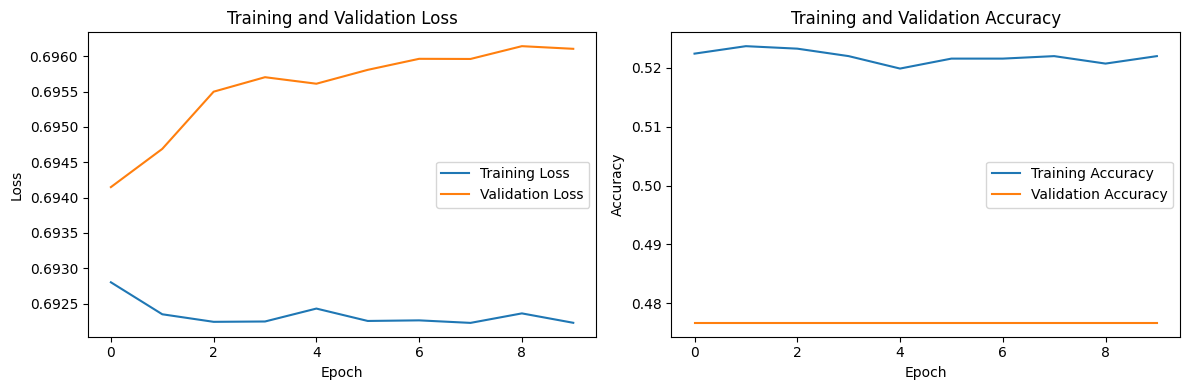

In [25]:
import matplotlib.pyplot as plt

# Modelin eğitim sürecindeki kayıp ve doğruluk değerlerini al
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Kayıp değerlerini grafiğe çiz
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Doğruluk değerlerini grafiğe çiz
plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
